In [1]:
import yfinance as yf  
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
ALPHA_VANTAGE_API_KEY = 'F80HDDVZM50CKH5C'
if ALPHA_VANTAGE_API_KEY == 'REPLACE-THIS-TEXT-WITH-A-REAL-API-KEY':
    raise Exception("Please provide a valid Alpha Vantage API key!")
import pytz
from datetime import timedelta
import pandas as pd
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler


In [165]:
plt.rcParams["figure.figsize"] = [10,10]
last_count=30

In [3]:
# data = yf.download('YESBANK.NS','2000-01-01','2020-01-01')
# data
# data.Close.plot()
# plt.show()

In [28]:
def modify(data,data_info):
    old_timezone = pytz.timezone(data_info["6. Time Zone"])
    new_timezone = pytz.timezone("Asia/Calcutta")
    data.columns=["open","high","low","close","volume"]
    data=data.reset_index()
    data=data.iloc[::-1].reset_index(drop=True)
    data["date"]=data["date"].apply(lambda x:old_timezone.localize(x).astimezone(new_timezone))
    for i in range(0,len(data)-1):
        data.loc[i,"timechange"]=(data.loc[i+1,"date"]-data.loc[i,"date"]).seconds//60
    data["weekday"]=data["date"].apply(lambda x:x.isoweekday())
    data["time"]=data["date"].apply(lambda x:x.time().hour*60+x.time().minute)
    data.loc[len(data)-1,"timechange"]=1066 if data.loc[len(data)-1,"time"]==929 else 1
    sc = MinMaxScaler(feature_range = (0, 1))
    data["close"] = sc.fit_transform(np.array(data["close"]).reshape(-1,1))
    return data
    

In [77]:
?nn.Conv1d

In [29]:
ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
intraday_data, data_info = ts.get_intraday('YESBANK.NS', outputsize='full', interval='1min')
intraday_data=modify(intraday_data,data_info)

In [190]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #First block
        self.layer1 = nn.Conv1d(1,10,stride=4,padding=2*4,kernel_size=4*5)
        self.drop1 = nn.MaxPool1d(2)
        self.flatten=nn.Flatten()
        
        self.layer2 = nn.LSTM(150,50)
        self.drop2 = nn.Dropout(0.2)
        
        self.layer3 = nn.LSTM(50, 50)
        self.drop3 = nn.Dropout(0.2)
        
        self.layer4 = nn.LSTM(50, 64)
        self.drop4 = nn.Dropout(0.2)
        
        self.layer5 = nn.LSTM(64, 50)
        self.drop5 = nn.Dropout(0.2)
       
        #         self.layer6 = nn.LSTM(128, 80)
        #         self.drop6 = nn.Dropout(0.2)

        #         self.layer7 = nn.LSTM(80, 50)
        #         self.drop7 = nn.Dropout(0.2)

        #         self.layer8 = nn.LSTM(50, 50)
        #         self.drop8 = nn.Dropout(0.2)
       
        self.endlayer = nn.Linear(50, 1)
        
        
    def forward(self,x):
        #First Block
        x=self.layer1(x)#.view(1,1,-1))
        x=self.drop1(x)
        x=self.flatten(x)
        #print(x)
        x,_=self.layer2(x.view(1,1,-1))
        x=self.drop2(x)
        
        x,_=self.layer3(x)
        x=self.drop3(x)
        
        x,_=self.layer4(x)
        x=self.drop4(x)
 
        x,_=self.layer5(x)
        x=self.drop5(x)
        
#         x,_=self.layer6(x)
#         x=self.drop6(x)
       
#         x,_=self.layer7(x)
#         x=self.drop7(x)
       
#         x,_=self.layer8(x)
#         x=self.drop8(x)
       
        x=self.endlayer(x)
        return x

In [202]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        
    def forward(self, y_pred):
        actual,pred = y_pred[0], y_pred[1]
        loss = torch.abs(actual**3-pred**3)
        return loss

In [203]:
def numpy2torch(arr):
    arr=np.array(arr).astype(float).reshape(1,1,-1)
    arr=Variable(torch.from_numpy(arr).float())
    return arr

In [204]:
model =Model()
loss_fn = Loss()
optimizer = optim.Adam(model.parameters())

In [205]:
for epoches in range(1):
    for i in tqdm(range(last_count,int(len(intraday_data)*0.9))):
        model.zero_grad()
        pred=model(numpy2torch(intraday_data.loc[i-last_count:i-1,["close" ,"timechange","weekday","time"]]))
        #pred=model(numpy2torch(intraday_data.loc[i-60:i-1,"close"]))
        #print(pred)
        loss=loss_fn([intraday_data.loc[i,"close"],pred])
        loss.backward()
        optimizer.step()
print("Loss",loss)



  0%|          | 0/1515 [00:00<?, ?it/s]

  0%|          | 7/1515 [00:00<00:22, 65.77it/s]

  1%|          | 14/1515 [00:00<00:22, 66.76it/s]

  1%|▏         | 22/1515 [00:00<00:21, 68.59it/s]

  2%|▏         | 30/1515 [00:00<00:21, 69.84it/s]

  3%|▎         | 38/1515 [00:00<00:20, 71.31it/s]

  3%|▎         | 46/1515 [00:00<00:20, 72.19it/s]

  3%|▎         | 53/1515 [00:00<00:20, 70.95it/s]

  4%|▍         | 61/1515 [00:00<00:19, 72.93it/s]

  5%|▍         | 69/1515 [00:00<00:19, 73.45it/s]

  5%|▌         | 77/1515 [00:01<00:20, 71.27it/s]

  6%|▌         | 85/1515 [00:01<00:19, 71.59it/s]

  6%|▌         | 93/1515 [00:01<00:20, 70.84it/s]

  7%|▋         | 102/1515 [00:01<00:19, 73.85it/s]

  7%|▋         | 110/1515 [00:01<00:19, 73.86it/s]

  8%|▊         | 118/1515 [00:01<00:18, 74.96it/s]

  8%|▊         | 126/1515 [00:01<00:19, 70.29it/s]

  9%|▉         | 134/1515 [00:01<00:21, 63.94it/s]

  9%|▉         | 141/1515 [00:02<00:21, 64.93it/s]

 10%|▉         | 148/1515 [00:02<

 78%|███████▊  | 1187/1515 [00:15<00:04, 73.61it/s]

 79%|███████▉  | 1195/1515 [00:15<00:04, 73.92it/s]

 79%|███████▉  | 1204/1515 [00:15<00:04, 76.11it/s]

 80%|████████  | 1213/1515 [00:15<00:03, 78.07it/s]

 81%|████████  | 1221/1515 [00:15<00:03, 78.23it/s]

 81%|████████  | 1229/1515 [00:16<00:03, 76.42it/s]

 82%|████████▏ | 1238/1515 [00:16<00:03, 78.53it/s]

 82%|████████▏ | 1246/1515 [00:16<00:03, 77.08it/s]

 83%|████████▎ | 1254/1515 [00:16<00:03, 77.61it/s]

 83%|████████▎ | 1263/1515 [00:16<00:03, 79.14it/s]

 84%|████████▍ | 1271/1515 [00:16<00:03, 79.39it/s]

 84%|████████▍ | 1280/1515 [00:16<00:02, 80.50it/s]

 85%|████████▌ | 1289/1515 [00:16<00:02, 80.75it/s]

 86%|████████▌ | 1298/1515 [00:16<00:02, 79.58it/s]

 86%|████████▌ | 1306/1515 [00:17<00:02, 79.44it/s]

 87%|████████▋ | 1314/1515 [00:17<00:02, 78.93it/s]

 87%|████████▋ | 1322/1515 [00:17<00:02, 78.26it/s]

 88%|████████▊ | 1330/1515 [00:17<00:02, 78.58it/s]

 88%|████████▊ | 1338/1515 [00:17<00:02, 76.44

Loss tensor([[[0.0082]]], grad_fn=<AbsBackward>)


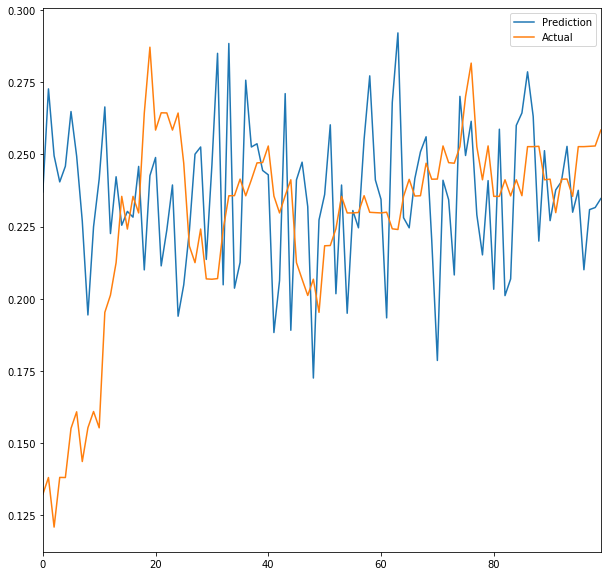

In [206]:
start=int(len(intraday_data)*0.9)
# pred=
# pred
pred=[]
actual=[]
last=list(np.array(intraday_data.loc[start-last_count:start-1,["close" ,"timechange","weekday","time"]]))
for i in range(100):
    #print(last60)
    prev=model(numpy2torch(last)).item()
    pred.append(prev)
    actual.append(intraday_data.loc[start+i,"close"])
    last=last[1:]+[[prev,last[0][1],last[0][2],last[0][3]+1]]
pd.DataFrame({"Prediction":pred,"Actual":actual}).plot()

In [131]:
pred

[57.01637649536133,
 59.878578186035156,
 49.03539276123047,
 55.945823669433594,
 56.92293930053711,
 51.79454803466797,
 54.22282409667969,
 55.762001037597656,
 54.55884552001953,
 50.23040771484375]

In [132]:
intraday_data.loc[1705,"close"]

55.95

In [29]:
prev_len=len(intraday_data)
while True:
    intraday_last100, data_info100 = ts.get_intraday('YESBANK.NS', interval='1min')
    intraday_last100=modify(intraday_last100,data_info100)
    intraday_data=pd.concat([intraday_data,intraday_last100]).drop_duplicates().reset_index(drop=True)
    for i in range(prev_len,len(intraday_data)):
        print(i)
    prev_len=len(intraday_data)
    break
    time.sleep(60)

In [33]:
intraday_data

,date,open,high,low,close,volume,timechange,weekday,time
0,2019-09-17 09:15:00+05:30,67.4013,67.5531,67.2529,67.5013,0.0,1.0,2,555
1,2019-09-17 09:16:00+05:30,67.5000,68.0000,67.5000,67.9000,1228504.0,1.0,2,556
2,2019-09-17 09:17:00+05:30,67.7524,68.4135,67.7128,68.3525,2341242.0,1.0,2,557
3,2019-09-17 09:18:00+05:30,68.4000,68.5000,68.0500,68.0500,1368883.0,1.0,2,558
4,2019-09-17 09:19:00+05:30,68.1022,68.2664,68.0662,68.1022,1472257.0,1.0,2,559
...,...,...,...,...,...,...,...,...,...
1868,2019-09-23 15:25:00+05:30,55.2015,55.3035,55.0533,55.1014,612812.0,1.0,1,925
1869,2019-09-23 15:26:00+05:30,55.0511,55.1934,55.0433,55.1511,247371.0,1.0,1,926
1870,2019-09-23 15:27:00+05:30,55.1021,55.2017,55.1016,55.1021,273211.0,1.0,1,927
1871,2019-09-23 15:28:00+05:30,55.1020,55.2012,55.0511,55.0520,452847.0,1.0,1,928


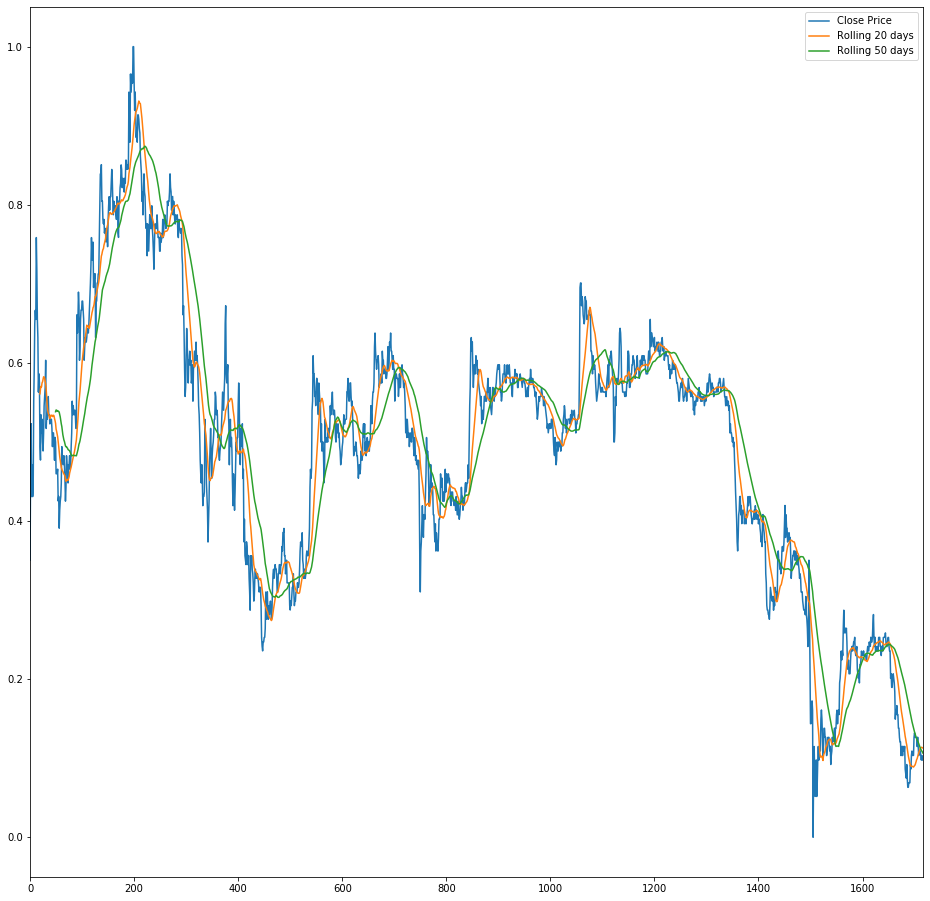

In [36]:
pd.DataFrame({"Close Price":intraday_data.close,
"Rolling 20 days":intraday_data.close.rolling(20).mean(),
"Rolling 50 days":intraday_data.close.rolling(50).mean()}).plot()